In [ ]:
!pip install tensorflow numpy pandas matplotlib scikit-learn

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import zipfile

In [2]:
dataset_path = '/content/waste_dataset.zip'  # Direct path to your uploaded zip
extract_path = '/content/waste_dataset'

In [3]:
# Create extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Unzip the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Extracted dataset to: {extract_path}")

# Verify extraction
print("\nExtracted folders:")
!ls {extract_path}

Extracted dataset to: /content/waste_dataset

Extracted folders:
 batteries   e-waste  'light blubs'   organic   plastic
 clothes     glass     metal	      paper


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen_train = ImageDataGenerator(rescale = 1/255, shear_range = 0.2, zoom_range = 0.2,
                               brightness_range = (0.1, 0.5), horizontal_flip=True)

train_data = gen_train.flow_from_directory("/content/waste_dataset",
                                           target_size = (224, 224), batch_size = 32, class_mode="categorical")

Found 8369 images belonging to 9 classes.


In [5]:
# let's create a model
# here i'm going to use VGG16 model's parameter to solve this problem

from tensorflow.keras.applications.vgg16 import VGG16

# here i'm going to take input shape, weights and bias from imagenet and include top False means
# i want to add input, flatten and output layer by my self

vgg16 = VGG16(input_shape = (224, 224, 3), weights = "imagenet", include_top = False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# now vgg16 weights are already train so i don't want to train that weights again
# so let's make trainable = False

for layer in vgg16.layers:
  layer.trainable = False

In [7]:
# let's add flatten layer or let's connect VGG16 with our own flatten layer

from tensorflow.keras import layers

x = layers.Flatten()(vgg16.output)

In [8]:
# now let's add output layers or prediction layer

prediction = layers.Dense(units = 9, activation="softmax")(x)

# creating a model object

model = tf.keras.models.Model(inputs = vgg16.input, outputs=prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │       225,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,940,489 (56.99 MB)

 Trainable params: 225,801 (882.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# now let's compile the model

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
result = model.fit(
    train_data,
    epochs=28,
    steps_per_epoch=len(train_data)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 168s 588ms/step - accuracy: 0.2878 - loss: 2.1546
Epoch 2/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 177s 542ms/step - accuracy: 0.4354 - loss: 1.6349
Epoch 3/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 205s 554ms/step - accuracy: 0.4838 - loss: 1.5151
Epoch 4/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 198s 539ms/step - accuracy: 0.5198 - loss: 1.3782
Epoch 5/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 142s 543ms/step - accuracy: 0.5319 - loss: 1.3668
Epoch 6/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 202s 545ms/step - accuracy: 0.5596 - loss: 1.2656
Epoch 7/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 145s 551ms/step - accuracy: 0.5750 - loss: 1.2482
Epoch 8/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 203s 558ms/step - accuracy: 0.5832 - loss: 1.2161
Epoch 9/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 146s 557ms/step - accuracy: 0.5946 - loss: 1.1918
Epoch 10/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 145s 553ms/step - accuracy: 0.5913 - loss: 1.2074
Epoch 11/28
262/262 ━━━━━━━━━━━━━━━━━━━━ 200s 547ms/step - accuracy: 0.6198 - loss: 1.1213
Epoch 12

In [10]:
from tensorflow.keras.preprocessing import image
output_class = ["batteries", "clothes", "e-waste", "glass", "light blubs", "metal", "organic", "paper", "plastic"]
def waste_prediction(new_image):
  test_image = image.load_img(new_image, target_size = (224,224))
  plt.axis("off")
  plt.imshow(test_image)
  plt.show()

  test_image = image.img_to_array(test_image) / 255
  test_image = np.expand_dims(test_image, axis=0)

  predicted_array = model.predict(test_image)
  predicted_value = output_class[np.argmax(predicted_array)]
  predicted_accuracy = round(np.max(predicted_array) * 100, 2)

  print("Your waste material is ", predicted_value, " with ", predicted_accuracy, " % accuracy")


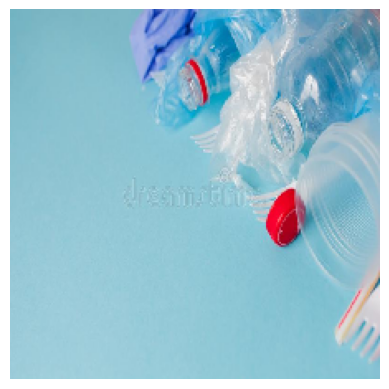

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Your waste material is  plastic  with  87.0  % accuracy


In [11]:
waste_prediction("item.jpg")

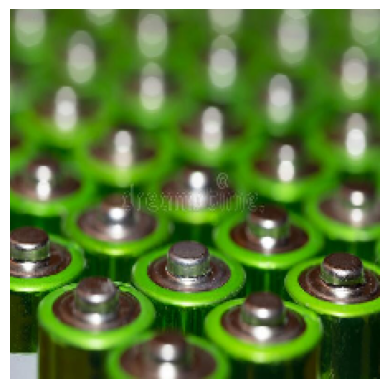

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Your waste material is  batteries  with  100.0  % accuracy


In [13]:
waste_prediction("item2.jpg")

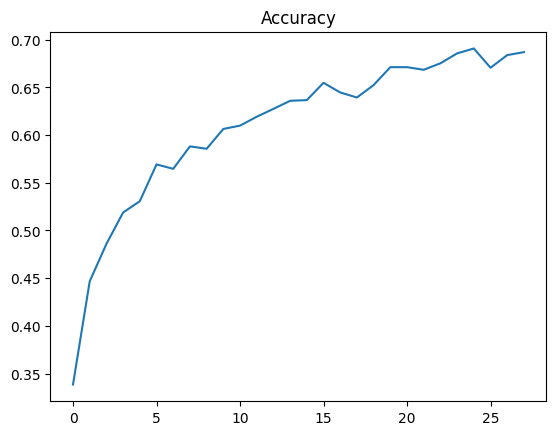

In [14]:
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.show()

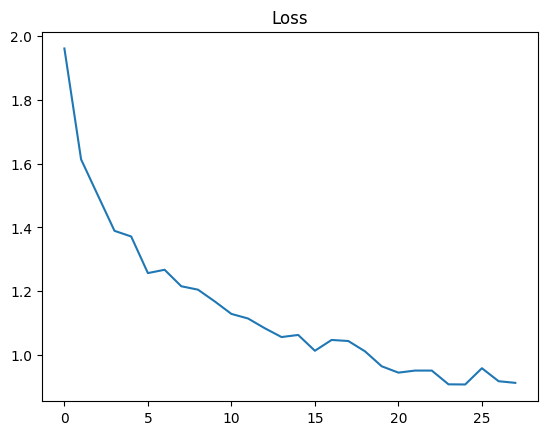

In [15]:
plt.title("Loss")
plt.plot(result.history["loss"])
plt.show()

In [ ]:
model.save("classifyWaste.h5")